In [ ]:
! pip install torch
! pip install torchvision
! pip install lightning
%pip install poutyne          # to install the Poutyne library
%pip install wget             # to install the wget library in order to download data
%pip install opencv-python    # to install the cv2 (opencv) library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8084e58a81ed2b8e55deb751de231d79b4d37e55c74772a9306462bda243ba2d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# Baza danych Celeba

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F


In [4]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=83f63a183c27b9b99f6ba70803ae06b07948f6f2f7386d810fe4185329825724
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [5]:
import wget
import zipfile
import os
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load CelebA dataset
train_dataset = datasets.CelebA(root=data_root,
                                split='train',
                                target_type=['attr'] ,
                                transform=transform,
                                download=False)

val_dataset = datasets.CelebA(root=data_root,
                              split='valid',
                                target_type=['attr'] ,
                              transform=transform,
                              download=False)

test_dataset = datasets.CelebA(root=data_root,
                              split='test',
                                target_type=['attr'] ,
                               transform=transform,
                              download=False)


In [ ]:

# Define a custom class to extract gender labels (1 for male, 0 for female)
class GenderDataset(torch.utils.data.Dataset):
    def __init__(self, celeba_dataset):
        self.celeba_dataset = celeba_dataset

    def __getitem__(self, index):
        image, attributes = self.celeba_dataset[index]
        gender = attributes[20]  # 20th index corresponds to 'Male' attribute
        return image, gender

    def __len__(self):
        return len(self.celeba_dataset)

# Create data loaders using the custom dataset
train_loader = DataLoader(GenderDataset(train_dataset), batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(GenderDataset(val_dataset), batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(GenderDataset(test_dataset), batch_size=4, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model klasyfikatora płci

In [2]:
class GenderCNN(nn.Module):
    def __init__(self):
        super(GenderCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  # 2 classes: Male and Female
        )


    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 16 * 32 * 32)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenderCNN().to(device)
print(model)

GenderCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [7]:
batch_size = 64
n_epochs = 15
patience = 5
learning_rate = 0.001

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Trening

In [ ]:
import numpy as np
import torchmetrics
import copy
train_losses = []
valid_losses = []


def train_model(model, patience, n_epochs):
    avg_train_losses = []
    avg_valid_losses = []
    last_loss = 100
    trigger_times = 0
    best_val_loss = float('inf')
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            running_loss += loss.item() * inputs.size(0)


        epoch_loss = running_loss / len(train_loader)
        train_loss = np.average(train_losses)
        avg_train_losses.append(train_loss)

# Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        accuracy_metric = torchmetrics.Accuracy(task='binary')
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets.float().view(-1, 1)).item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                # correct += (predicted == targets).sum().item()
                valid_losses.append(loss.item())
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)

        predictions_array = np.array(all_predictions)
        labels_array = np.array(all_labels)
        # accuracy = correct / total

        print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}, Validation Loss: {valid_loss:.4f},")

         # Check for improvement
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            counter += 1

        # Check if early stopping criteria met
        if counter >= patience:
            print("Early stopping! No improvement for {} epochs.".format(patience))
            break

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'gender_classification_model.pth')
    return  model, avg_train_losses, avg_valid_losses

model, train_loss, valid_loss  = train_model(model, patience, n_epochs)

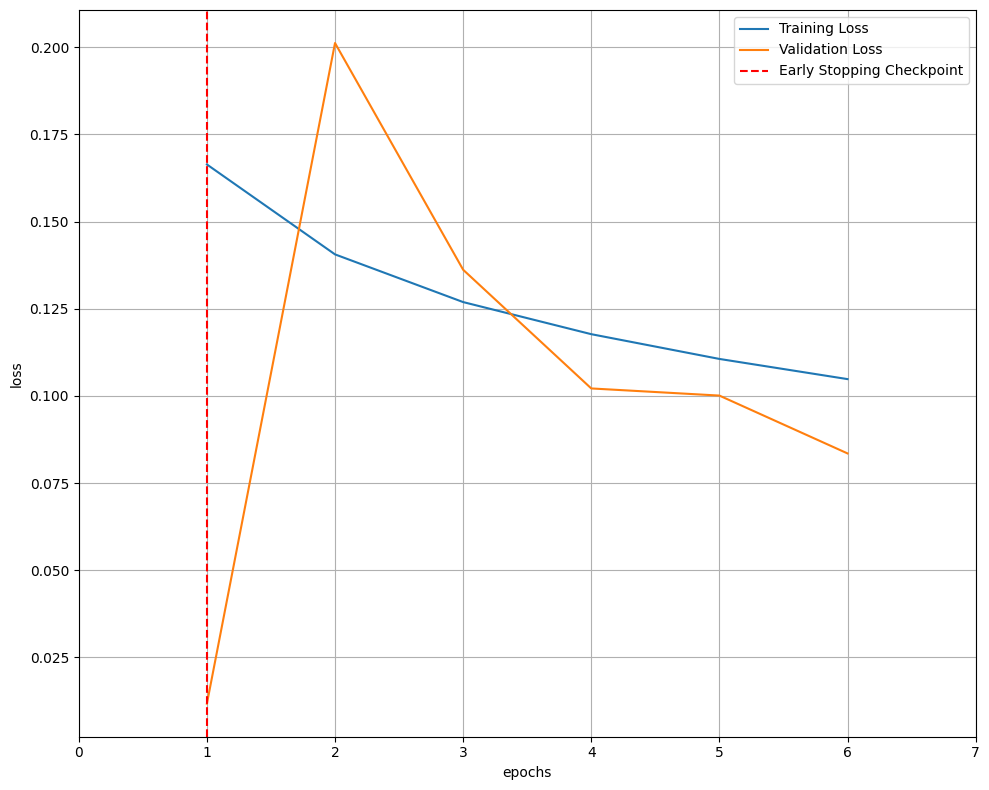

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 0.5)
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')





# Testowanie

## Na zbiorze Celeba

In [14]:
model.load_state_dict(torch.load(r'/content/gender_classification_model.pth'))


<All keys matched successfully>

<Figure size 400x800 with 0 Axes>

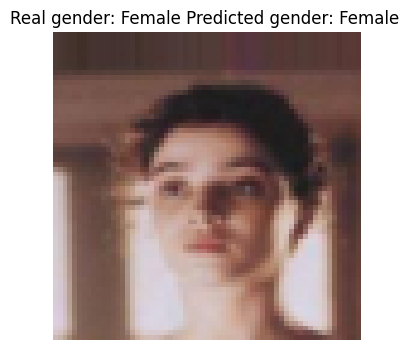

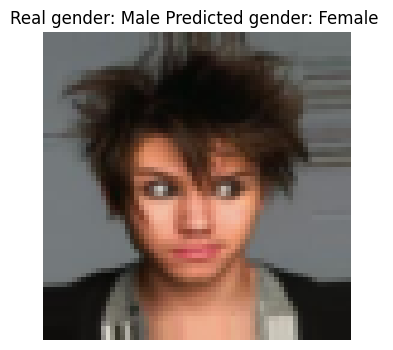

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def get_img(test_dataset):
    idx = np.random.randint(0, len(test_dataset))  # Losowy indeks w batchu
    img = test_dataset[idx][0]
    label = test_dataset[idx][1]

    male_index = 20
    real_gender = get_gender(label[male_index])
    model.eval()
    with torch.no_grad():
        im = img.to(device).unsqueeze(0)
        output = model(im)
        pred = output

    pred = pred.cpu().numpy().flatten()
    pred_gender = get_gender(pred[0])
    return img, real_gender, pred_gender


def get_gender(pred):
    pred_gender = None
    if pred > 0.5:
        pred_gender = "Male"
    else:
        pred_gender = "Female"
    return pred_gender

def pic(img, real_gender, pred_gender):
  plt.figure(figsize=(4, 4))
  img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Real gender: {real_gender} Predicted gender: {pred_gender} ")
  plt.show()


# Wyświetlanie obrazu z predykcjami i etykietami rzeczywistymi
gender = 0
figure = plt.figure(figsize=(4, 8))
cols, rows = 1, 2
# for i in range(1, cols * rows + 1):
img, real_gender, pred_gender = get_img(test_dataset)
pic(img, real_gender, pred_gender)
while (real_gender == pred_gender):
  img, real_gender, pred_gender = get_img(test_dataset)
pic(img, real_gender, pred_gender)






<ipython-input-111-067a358584a0>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  y_true_tensor = torch.tensor(y_true)


Test Accuracy: 96.09%


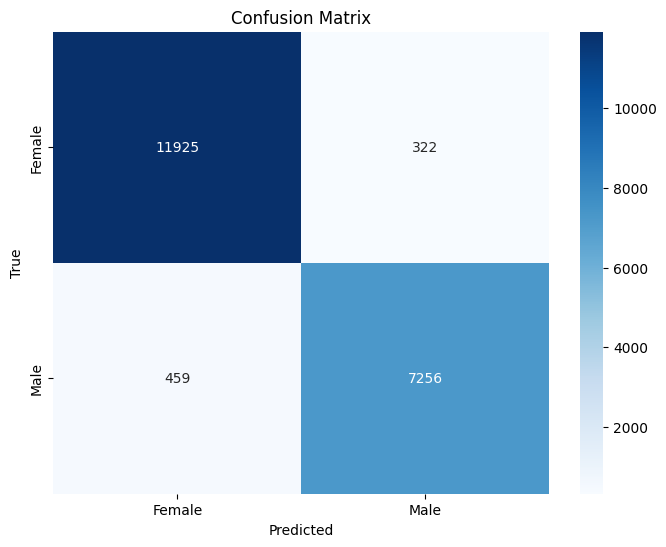

In [ ]:
import seaborn as sns
import torchmetrics

accuracy = torchmetrics.Accuracy(task='binary')
matrix = torchmetrics.ConfusionMatrix(task = 'binary')
y_pred = []
y_true = []
model.eval()
val_loss = 0
threshold = 0.5

with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data)
      val_loss += criterion(outputs, target.float().view(-1, 1)).item()
      target = target.float().view(-1, 1)
      y_true.extend((target >= threshold).int().cpu().numpy())
      y_pred.extend((outputs >= threshold).int().cpu().numpy())


y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

accuracy_value = accuracy(y_pred_tensor, y_true_tensor)
print(f"Test Accuracy: {accuracy_value * 100:.2f}%")
cm = matrix(y_pred_tensor, y_true_tensor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('conf_matrix_gender.png', bbox_inches='tight')
plt.show()

## Na zbiorze WIDERFACE

In [8]:
import zipfile
import os

data_root = "datasets"

dataset_folder = f"{data_root}/widerface"
os.makedirs(dataset_folder, exist_ok=True)

with zipfile.ZipFile(f"/content/widerface.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [9]:
import torchvision
import torch
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import os
from posixpath import abspath, expanduser
import numpy as np
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class WIDERFaceTest(torchvision.datasets.WIDERFace):


    def __init__(self, root: str, split: str = "train", transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False, face_transform:Optional[Callable] = None ) -> None:
       self.face_transform = face_transform

       super().__init__(root, split, transform, target_transform, download)


    def parse_train_val_annotations_file(self) -> None:
        filename = "wider_face_train_bbx_gt.txt" if self.split == "train" else "wider_face_val_bbx_gt.txt"
        filepath = os.path.join(self.root, "wider_face_split", filename)

        with open(filepath) as f:
            lines = f.readlines()
            file_name_line, num_boxes_line, box_annotation_line = True, False, False
            num_boxes, box_counter = 0, 0
            labels = []
            for line in lines:
                line = line.rstrip()
                if file_name_line:
                    img_path = os.path.join(self.root, "WIDER_" + self.split, "images", line)
                    # img_path = abspath(expanduser(img_path))
                    file_name_line = False
                    num_boxes_line = True
                elif num_boxes_line:
                    num_boxes = int(line)
                    num_boxes_line = False
                    box_annotation_line = True
                elif box_annotation_line:
                    box_counter += 1
                    line_split = line.split(" ")
                    line_values = [int(x) for x in line_split]
                    labels.append(line_values)
                    if box_counter >= num_boxes:
                        box_annotation_line = False
                        file_name_line = True
                        labels_tensor = torch.tensor(labels)
                        faces = []
                        for i in range(len(labels)):
                          img = Image.open(img_path)
                          x = labels[i][0] - (labels[i][2] / 5)
                          y = labels[i][1] - (labels[i][3] / 5)
                          w = labels[i][2] + (labels[i][2] / 5)
                          h = labels[i][3] + (labels[i][3] / 5)
                          box = [x,y,x+w,y+h]
                          img = img.crop(box)
                          img = self.face_transform(img)
                          faces.append(img)
                        self.img_info.append(
                            {
                                "img_path": img_path,
                                "annotations": {
                                    "bbox": labels_tensor[:, 0:4].clone(),  # x, y, width, height
                                    "gender" : labels_tensor[:, 10].clone(),
                                    "glasses" : labels_tensor[:, 11].clone(), 
                                    'faces': faces.copy(),

                                },
                            }
                        )
                        box_counter = 0
                        labels.clear()
                else:
                    raise RuntimeError(f"Error parsing annotation file {filepath}")

        def __getitem__(self, index: int):
          target = None if self.split == "test" else self.img_info[index]["annotations"]
          if self.target_transform is not None:
              target = self.target_transform(target)
          return self.img_info[index]["faces"], target

class WIDERFaceDataset(torch.utils.data.Dataset):
    def __init__(self, widerface_dataset):
        self.widerface_dataset = widerface_dataset

    def __getitem__(self, index):
        faces, target = self.widerface_dataset[index]
        return target['faces'], target['gender']

    def __len__(self):
        return len(self.widerface_dataset)




In [17]:
imagenet_data =  torchvision.datasets.WIDERFace(f'{datasets}', download=True, split='train')


Using downloaded and verified file: datasets/data/widerface/WIDER_train.zip


362752168it [00:05, 70676401.15it/s]
1844140520it [00:26, 69418731.65it/s]


100%|██████████| 3591642/3591642 [00:00<00:00, 36121680.31it/s]

Extracting datasets/data/widerface/wider_face_split.zip to datasets/data/widerface


In [18]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
imagenet_data =  WIDERFaceTest('/content/datasets/data', download=False, split='train', face_transform=transform)
widerface_loader = DataLoader(WIDERFaceDataset(imagenet_data), batch_size=1, shuffle=True, num_workers=1 )


In [17]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.8 MB/s eta 0:00:00


Test Accuracy: 55.15%


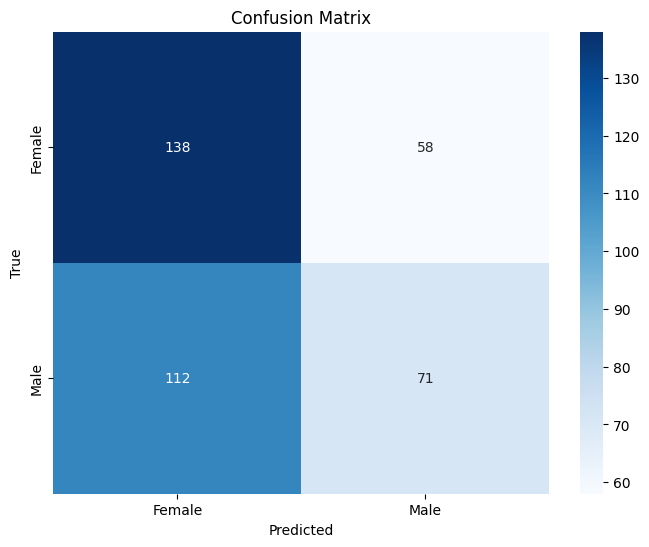

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

import torchmetrics
accuracy = torchmetrics.Accuracy(task='binary')
matrix = torchmetrics.ConfusionMatrix(task = 'binary')
y_pred = []
y_true = []
model.eval()
val_loss = 0
threshold = 0.5
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

with torch.no_grad():
  for data, target in widerface_loader:
      target = target[0]
      outputs = []
      for i in range(len(target)):
        if target[i] == 1: 
          real = torch.tensor([[0]])
        else:
          real = torch.tensor([[1]])
        inn, label = data[i].to(device), real.to(device)
        output = model(inn)
        y_pred.extend((output >= threshold).int().cpu().numpy())
        y_true.extend((real >= threshold).int().cpu().numpy())

y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

accuracy_value = accuracy(y_pred_tensor, y_true_tensor)
print(f"Test Accuracy: {accuracy_value * 100:.2f}%")
cm = matrix(y_pred_tensor, y_true_tensor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def get_img(test_dataset):
    idx = np.random.randint(0, len(test_dataset))  # Losowy indeks w batchu
    img = test_dataset[idx][1]['faces']
    label = test_dataset[idx][1]['gender']
    outputs= []
    real = []
    model.eval()
    with torch.no_grad():
      for i in range(len(img)):
        if label[i] == 1:
          real.extend(torch.tensor([0]))
        else:
          real.extend(torch.tensor([1]))
        im = img[i].to(device).unsqueeze(0)
        output = model(im)
        pred = output
        outputs.extend(pred)

    real_gender = get_gender(real)
    pred_gender = get_gender(outputs)
    return img, real_gender, pred_gender, test_dataset[idx][0]


def get_gender(pred):
    pred_gender = ""
    out = []
    for i in pred:
      if i > 0.5:
          pred_gender = "Male"
      else:
          pred_gender = "Female"
      out.append(pred_gender)
    return out

def pic(img, real_gender, pred_gender):
  plt.figure(figsize=(4, 4))
  # img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Real gender: {real_gender}\n Predicted gender: {pred_gender} ")
  plt.show()


# Wyświetlanie obrazu z predykcjami i etykietami rzeczywistymi
gender = 0
figure = plt.figure(figsize=(4, 8))
cols, rows = 1, 2
# for i in range(1, cols * rows + 1):
img, real_gender, pred_gender, full = get_img(imagenet_data)
pic(full, real_gender, pred_gender)
